## Library

In [1]:
import os
import zipfile
import pandas as pd

import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.model_selection import train_test_split

## kaggle

In [2]:
with open(".env") as f:
    for line in f:
        key, val = line.strip().split("=")
        os.environ[key] = val

# print("Kaggle user:", os.environ['KAGGLE_USERNAME'])  
# print("Kaggle user:", os.environ['KAGGLE_KEY'])  

In [ ]:
# !mkdir -p Data
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p Data

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other




  0%|          | 0.00/2.29G [00:00<?, ?B/s]
  2%|▏         | 48.0M/2.29G [00:00<00:04, 498MB/s]
  4%|▍         | 100M/2.29G [00:00<00:04, 522MB/s] 
  6%|▋         | 150M/2.29G [00:00<00:04, 492MB/s]
  9%|▉         | 211M/2.29G [00:00<00:04, 547MB/s]
 11%|█         | 264M/2.29G [00:00<00:05, 403MB/s]
 13%|█▎        | 307M/2.29G [00:00<00:05, 360MB/s]
 15%|█▍        | 346M/2.29G [00:00<00:05, 351MB/s]
 17%|█▋        | 393M/2.29G [00:01<00:05, 386MB/s]
 19%|█▊        | 435M/2.29G [00:01<00:05, 400MB/s]
 21%|██        | 484M/2.29G [00:01<00:04, 431MB/s]
 22%|██▏       | 527M/2.29G [00:01<00:04, 415MB/s]
 24%|██▍       | 569M/2.29G [00:01<00:04, 421MB/s]
 26%|██▌       | 611M/2.29G [00:01<00:04, 390MB/s]
 28%|██▊       | 669M/2.29G [00:01<00:03, 448MB/s]
 31%|███       | 721M/2.29G [00:01<00:03, 475MB/s]
 33%|███▎      | 768M/2.29G [00:01<00:03, 441MB/s]
 35%|███▍      | 812M/2.29G [00:02<00:03, 413MB/s]
 36%|███▋      | 853M/2.29G [00:02<00:04, 362MB/s]
 38%|███▊      | 894M/2.29G [00:02<

In [ ]:
# with zipfile.ZipFile("Data/chest-xray-pneumonia.zip", "r") as zip_ref:
#     zip_ref.extractall("Data/")

## Data preparation

**1) Pull data from folder** 

In [2]:
def make_dataframe(base_dir):
    filepaths = []
    labels = []

    for split in ["train", "val", "test"]:
        for label_dir in ["NORMAL", "PNEUMONIA"]:
            path = os.path.join(base_dir, split, label_dir)
            for filename in os.listdir(path):
                filepaths.append(os.path.join(path, filename))
                labels.append(0 if label_dir == "NORMAL" else 1)

    df = pd.DataFrame({
        "filepath": filepaths,
        "label": labels
    })
    return df

base_dir = "Data/chest_xray" # Your path -------------------------------------------------------------
df_all = make_dataframe(base_dir)
print(len(df_all))
df_all['label'].value_counts()

5856


label
1    4273
0    1583
Name: count, dtype: int64

**2) Image size**

ทำการดูว่าจากภาพทั้งหมดมีภาพขนาด size เท่าไหร่บ้าง

In [3]:
widths = []
heights = []

for path in tqdm(df_all["filepath"], desc="Checking image sizes"):
    try:
        with Image.open(path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except:
        widths.append(None)
        heights.append(None)

df_all["width"] = widths
df_all["height"] = heights

print("Image Size Summary (pixels)")
display(df_all[["width", "height"]].describe().round(1))


Checking image sizes: 100%|██████████| 5856/5856 [00:07<00:00, 808.12it/s]

Image Size Summary (pixels)


,width,height
count,5856.0,5856.0
mean,1327.9,970.7
std,363.5,383.4
min,384.0,127.0
25%,1056.0,688.0
50%,1281.0,888.0
75%,1560.0,1187.0
max,2916.0,2713.0


Most common image sizes:
Distribution โดยรวม


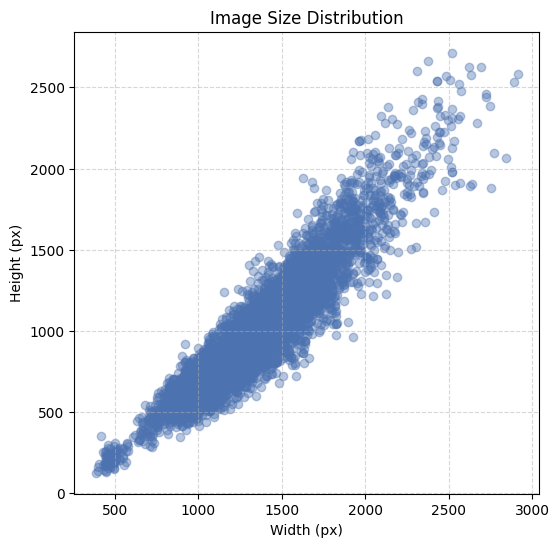

In [4]:
mode_size = df_all.groupby(["width", "height"]).size().reset_index(name="count").sort_values("count", ascending=False)
print("Most common image sizes:")
# display(mode_size.head())

print("Distribution โดยรวม")
plt.figure(figsize=(6,6))
plt.scatter(df_all["width"], df_all["height"], alpha=0.4, color="#4C72B0")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Image Size Distribution")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


จากกราฟจะเห็นได้ว่า Width, Height ที่ช่วง 0 - 500 มีข้อมูลเกาะกลุ่มกันจึงทำการสำรวจเพิ่มเติมว่า ภาพที่มีความสูงความกว้างที่น้อยมีภาพเป็นอย่างไร

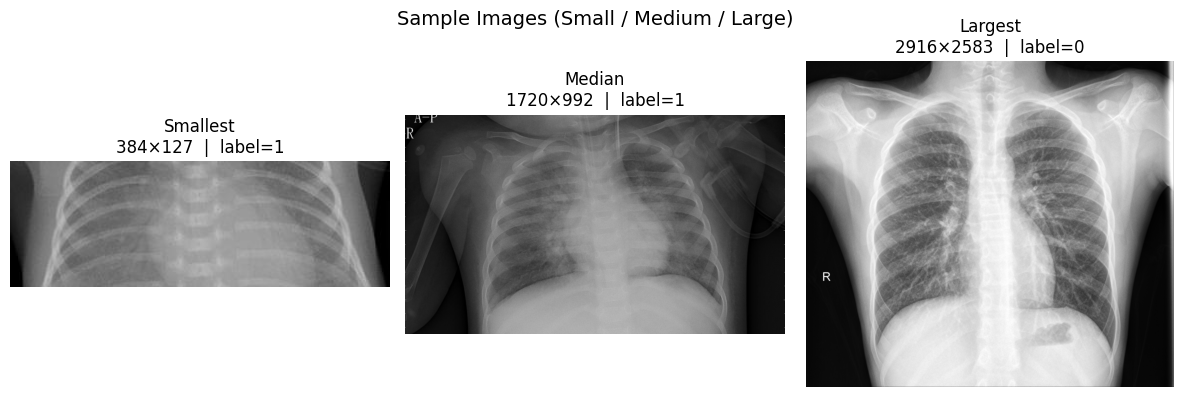

In [5]:
smallest = df_all.sort_values(by=["width", "height"]).iloc[0]
median = df_all.iloc[len(df_all)//2]
largest = df_all.sort_values(by=["width", "height"], ascending=False).iloc[0]

samples = [("Smallest", smallest), ("Median", median), ("Largest", largest)]

plt.figure(figsize=(12,4))

for i, (title, row) in enumerate(samples):
    plt.subplot(1, 3, i+1)
    img = Image.open(row["filepath"])
    plt.imshow(img, cmap='gray')
    plt.title(f"{title}\n{row['width']}×{row['height']}  |  label={row['label']}")
    plt.axis("off")

plt.suptitle("Sample Images (Small / Medium / Large)", fontsize=14)
plt.tight_layout()
plt.show()

พบภาพที่ความสูง < 300 px ทั้งหมด 76 ภาพ


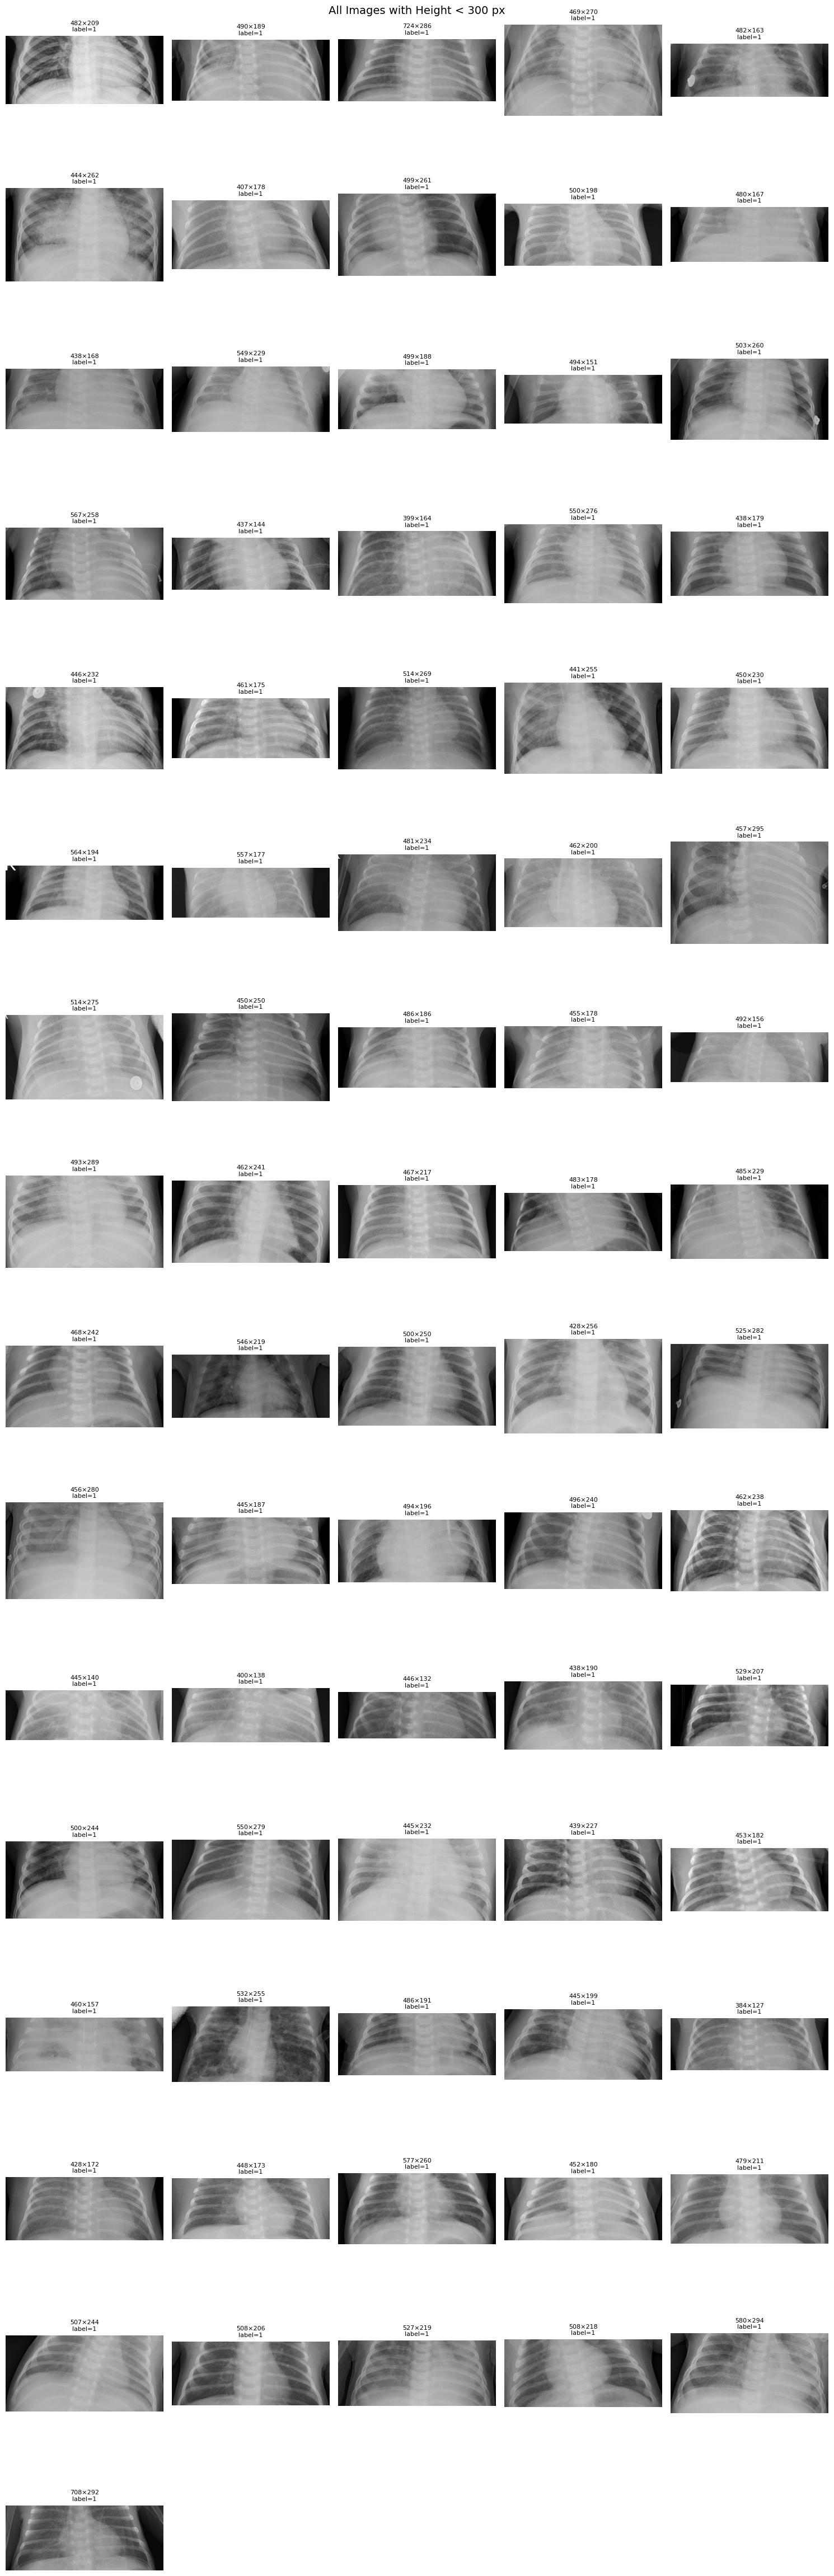

In [8]:
small_imgs = df_all[df_all["height"] < 300]

print(f"พบภาพที่ความสูง < 300 px ทั้งหมด {len(small_imgs)} ภาพ")
n = len(small_imgs)
cols = 5
rows = (n // cols) + 1

plt.figure(figsize=(15, 3 * rows))
for i, (_, row) in enumerate(small_imgs.iterrows()):
    plt.subplot(rows, cols, i+1)
    try:
        img = Image.open(row["filepath"])
        plt.imshow(img, cmap="gray")
        plt.title(f"{row['width']}×{row['height']}\nlabel={row['label']}", fontsize=8)
        plt.axis("off")
    except Exception as e:
        plt.text(0.5, 0.5, "Error", ha="center", va="center")
        plt.axis("off")

plt.suptitle("All Images with Height < 300 px", fontsize=14)
plt.tight_layout()
plt.show()


## Delete crop images

In [17]:
df_train = df_all[df_all["filepath"].str.contains("train")]
df_val = df_all[df_all["filepath"].str.contains("val")]
df_test = df_all[df_all["filepath"].str.contains("test")]

In [18]:
bad_images = df_all[df_all["height"] < 250]["filepath"]
print(f"พบภาพที่ต้องลบทั้งหมด {len(bad_images)} ภาพ\n")

df_all = df_all[~df_all["filepath"].isin(bad_images)]
df_train = df_train[~df_train["filepath"].isin(bad_images)]
df_val   = df_val[~df_val["filepath"].isin(bad_images)]
df_test  = df_test[~df_test["filepath"].isin(bad_images)]

print("Updated dataset counts:")
print(f"All:   {len(df_all)}")
print(f"Train: {len(df_train)}")
print(f"Val:   {len(df_val)}")
print(f"Test:  {len(df_test)}")


พบภาพที่ต้องลบทั้งหมด 0 ภาพ

Updated dataset counts:
All:   5802
Train: 5162
Val:   16
Test:  624


**3) check channel of images**

ทำการเช็คว่าภาพทั้งหมดจาก Dataset มีภาพที่เป็น Grayscale และ RGB จำนวนเท่าไหร่

In [19]:
modes = []
for path in tqdm(df_all["filepath"], desc="Checking image color mode"):
    try:
        with Image.open(path) as img:
            modes.append(img.mode)
    except:
        modes.append(None)

df_all["mode"] = modes


print("Image Mode Summary:")
display(df_all["mode"].value_counts())


Checking image color mode: 100%|██████████| 5802/5802 [00:01<00:00, 3242.61it/s]

Image Mode Summary:


mode
L      5573
RGB     229
Name: count, dtype: int64

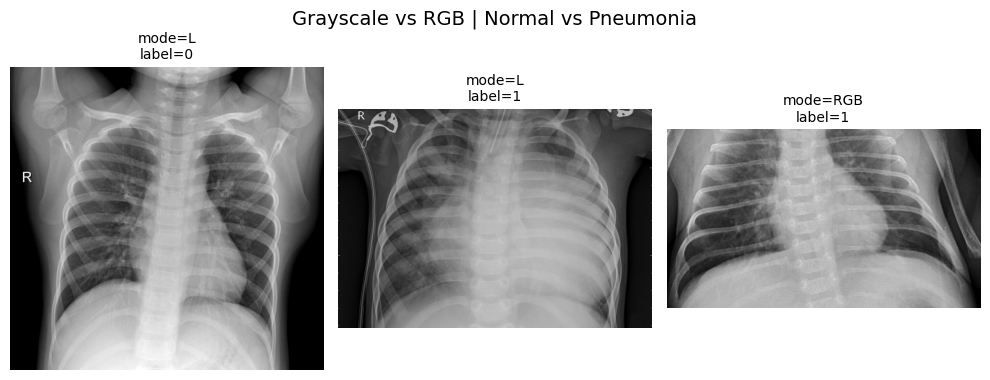

In [24]:
gray_normal     = df_all[(df_all["mode"] == "L")   & (df_all["label"] == 0)]
gray_pneumonia  = df_all[(df_all["mode"] == "L")   & (df_all["label"] == 1)]
rgb_normal      = df_all[(df_all["mode"] == "RGB") & (df_all["label"] == 0)]
rgb_pneumonia   = df_all[(df_all["mode"] == "RGB") & (df_all["label"] == 1)]

samples = pd.concat([
    gray_normal.sample(min(1, len(gray_normal)), random_state=123),
    gray_pneumonia.sample(min(1, len(gray_pneumonia)), random_state=4236),
    rgb_normal.sample(min(1, len(rgb_normal)), random_state=23412),
    rgb_pneumonia.sample(min(1, len(rgb_pneumonia)), random_state=222122),
])

plt.figure(figsize=(10, 4))
for i, (_, row) in enumerate(samples.iterrows()):
    img = Image.open(row["filepath"])
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap="gray" if row["mode"] == "L" else None)
    plt.title(f"mode={row['mode']}\nlabel={row['label']}", fontsize=10)
    plt.axis("off")

plt.suptitle("Grayscale vs RGB | Normal vs Pneumonia", fontsize=14)
plt.tight_layout()
plt.show()


จากภาพทั้งหมด มี    
Grayscale     5573  
RGB           229   
และภาพ RGB และภาพ Grayscale ก็มีความต่างกันไม่มากและภาพจะถูก crop มาเล็กน้อย ซึ่งถ้าเป็นภาพที่เป็น RGB จะไม่มี Normal ภาพที่เป็น RGB ทั้งหมดจะเป็นโรคปอดอักเสบ  
ดังนั้นจะทำการแปลงเป็น RGB ทั้งหมดเนื่องจาก เป้าหมายในการเลือก model มา train จะเป็น Transfer learning เช่น Resnet ViT ซึ่งจะรองรับเฉพาะ RGB เท่านั้นและถึงจะเป็นเป็น RGB ภาพเดิมที่เป็น Grayscale ก็ยังคงเดิมข้อมูลไม่เปลี่ยนแปลง

## Convert all image to RGB

# รันครั้งเดียว แล้ว comment ไว้

In [ ]:
# new_dir = "Data/chest_xray_new"
# os.makedirs(new_dir, exist_ok=True)

# all_paths = pd.concat([df_all, df_train, df_val, df_test])["filepath"].unique()

# print(f"กำลังสร้างภาพ RGB ทั้งหมด {len(all_paths)} ไฟล์ ไปยัง: {new_dir}")

# for path in tqdm(all_paths, desc="Converting to RGB (new folder)"):
#     try:
#         rel_name = os.path.basename(path)
#         dst_path = os.path.join(new_dir, rel_name)

#         with Image.open(path) as img:
#             rgb_img = img.convert("RGB")
#             rgb_img.save(dst_path)
#     except Exception as e:
#         print(f"⚠️ Error converting {path}: {e}")

# print("แปลงภาพทั้งหมดเป็น RGB และบันทึกใน Data/chest_xray_new เรียบร้อยแล้ว")


กำลังสร้างภาพ RGB ทั้งหมด 5802 ไฟล์ ไปยัง: Data/chest_xray_new


Converting to RGB (new folder):   0%|          | 0/5802 [00:00<?, ?it/s]

Converting to RGB (new folder): 100%|██████████| 5802/5802 [04:02<00:00, 23.89it/s]


✅ แปลงภาพทั้งหมดเป็น RGB และบันทึกใน Data/chest_xray_new เรียบร้อยแล้ว
✅ อัปเดต path ใน df_all, df_train, df_val, df_test เรียบร้อยแล้ว

📁 ตัวอย่าง path หลังอัปเดต:
0    Data/chest_xray_new\IM-0115-0001.jpeg
1    Data/chest_xray_new\IM-0117-0001.jpeg
2    Data/chest_xray_new\IM-0119-0001.jpeg
3    Data/chest_xray_new\IM-0122-0001.jpeg
4    Data/chest_xray_new\IM-0125-0001.jpeg
Name: filepath, dtype: object

📊 ตรวจสอบจำนวนไฟล์:
df_all_new  : 5802
df_train_new: 5162
df_val_new  : 16
df_test_new : 624


In [52]:
def update_paths(df, new_dir):
    df = df.copy()
    df["filepath"] = df["filepath"].apply(lambda x: os.path.join(new_dir, os.path.basename(x)))
    return df

df_all_new  = update_paths(df_all, "Data/chest_xray_new")
df_train_new = update_paths(df_train, "Data/chest_xray_new")
df_val_new   = update_paths(df_val, "Data/chest_xray_new")
df_test_new  = update_paths(df_test, "Data/chest_xray_new")


df_train_new = df_train_new[~df_train_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)
df_val_new   = df_val_new[~df_val_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)
df_test_new  = df_test_new[~df_test_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)

print("path ใน df_all, df_train, df_val, df_test")

print("ตรวจสอบจำนวนไฟล์:")
print(f"df_all_new  : {len(df_all_new)}")
print(f"df_train_new: {len(df_train_new)}")
print(f"df_val_new  : {len(df_val_new)}")
print(f"df_test_new : {len(df_test_new)}")

path ใน df_all, df_train, df_val, df_test
ตรวจสอบจำนวนไฟล์:
df_all_new  : 5802
df_train_new: 5162
df_val_new  : 16
df_test_new : 624


โดยสรุป Data preparation
จากภาพทั้งหมดมี 5856 ภาพ...

## Exploratory Data Analysis

**1) Histogram**

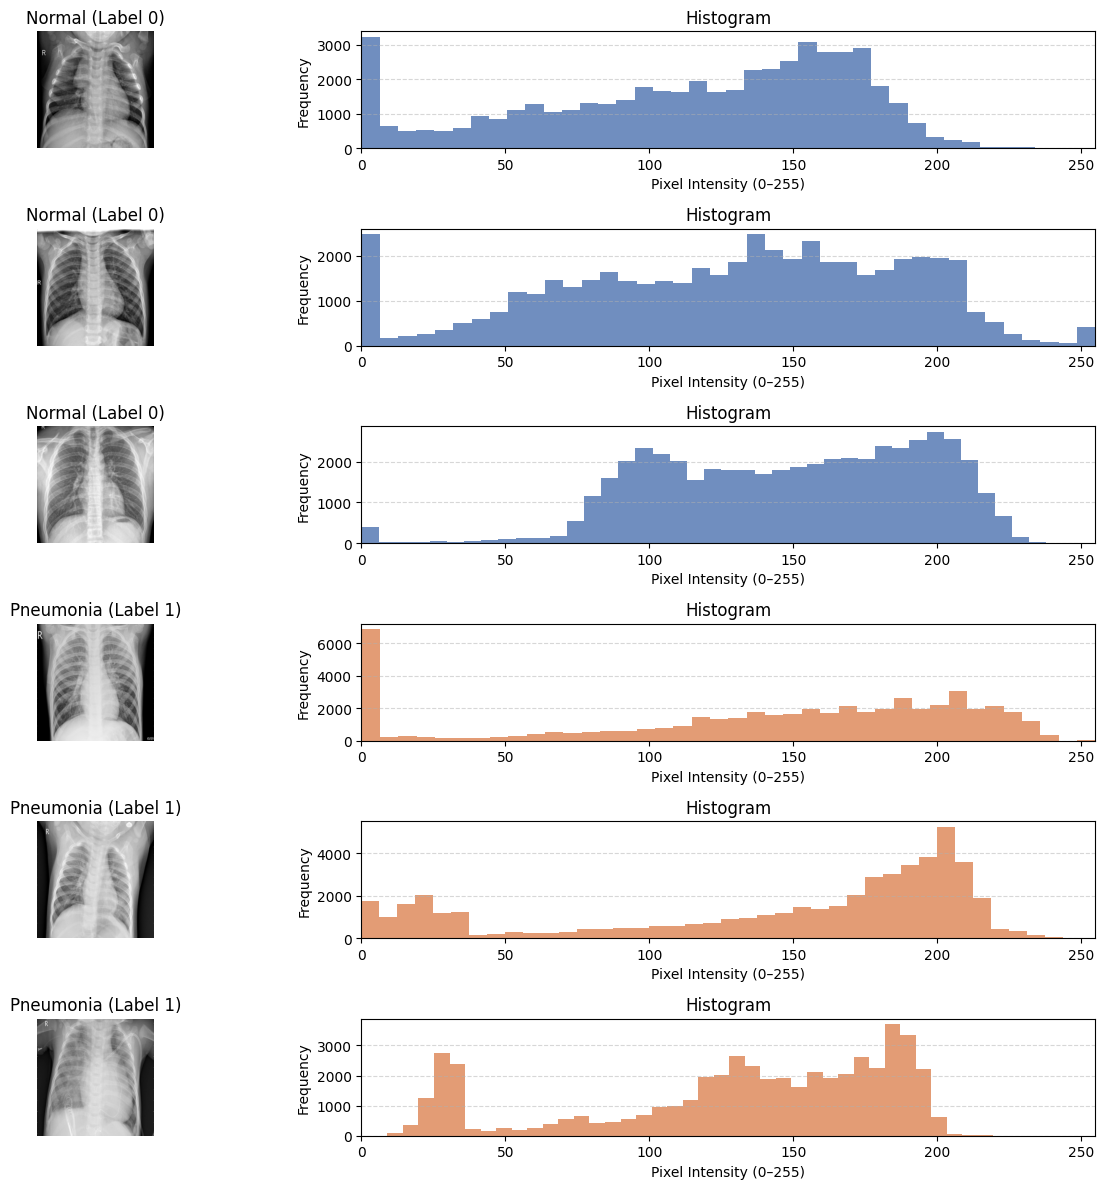

In [28]:
samples_0 = df_all_new[df_all_new["label"] == 0].sample(3, random_state=2343)
samples_1 = df_all_new[df_all_new["label"] == 1].sample(3, random_state=3343)

resize_size = (224, 224)
plt.figure(figsize=(14, 12))

def plot_image_and_hist(row, index, label_name, color):
    img = Image.open(row["filepath"]).convert("L").resize(resize_size)
    arr = np.array(img)

    # ภาพจริง
    plt.subplot(6, 2, 2*index - 1)
    plt.imshow(arr, cmap="gray")
    plt.title(f"{label_name} (Label {row['label']})", fontsize=12)
    plt.axis("off")

    # histogram
    plt.subplot(6, 2, 2*index)
    plt.hist(arr.ravel(), bins=40, color=color, alpha=0.8)
    plt.xlim(0, 255)  
    plt.xlabel("Pixel Intensity (0–255)", fontsize=10)
    plt.ylabel("Frequency", fontsize=10)
    plt.title("Histogram", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

for i, (_, row) in enumerate(samples_0.iterrows(), start=1):
    plot_image_and_hist(row, i, "Normal", "#4C72B0")

for i, (_, row) in enumerate(samples_1.iterrows(), start=4):
    plot_image_and_hist(row, i, "Pneumonia", "#DD8452")

plt.tight_layout()
plt.show()


จากกราฟจะเห็นว่า ภาพที่ป่วยเป็นปอดอักเสบ Histogram จะมีความเบ้ซ้ายคือ pixel ส่วนมากจะเอนเอี่ยงไปทางช่วง 200 เยอะแสดงถึงมีสีขาวเยอะ

**2) Class distribution**

Class Distribution by Dataset


label,0,1,Total,% Normal (0),% Pneumonia (1)
All,1583,4219,5802,27.3,72.7
Train,1341,3821,5162,26.0,74.0
Val,8,8,16,50.0,50.0
Test,234,390,624,37.5,62.5


<Figure size 800x500 with 0 Axes>

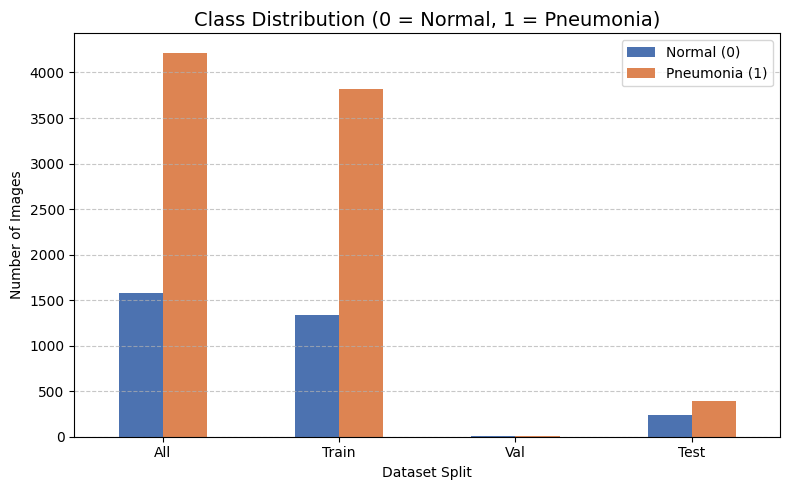

In [29]:
counts_train = df_train_new['label'].value_counts().sort_index()
counts_val = df_val_new['label'].value_counts().sort_index()
counts_test = df_test_new['label'].value_counts().sort_index()
counts_all = df_all_new['label'].value_counts().sort_index()

df_summary = pd.DataFrame({
    'All': counts_all,
    'Train': counts_train,
    'Val': counts_val,
    'Test': counts_test,

}).T.fillna(0).astype(int)

df_summary['Total'] = df_summary[0] + df_summary[1]
df_summary['% Normal (0)'] = (df_summary[0] / df_summary['Total'] * 100).round(1)
df_summary['% Pneumonia (1)'] = (df_summary[1] / df_summary['Total'] * 100).round(1)

print("Class Distribution by Dataset")
display(df_summary)

plt.figure(figsize=(8,5))
df_summary[[0,1]].plot(
    kind='bar',
    stacked=False,
    color=['#4C72B0', '#DD8452'],
    figsize=(8,5)
)
plt.title('Class Distribution (0 = Normal, 1 = Pneumonia)', fontsize=14)
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(['Normal (0)', 'Pneumonia (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Data splitting

In [53]:
df_val_old = df_val_new.copy()
df_test_old = df_test_new.copy()
df_train_old = df_train_new.copy()

print("Train:", len(df_train_old))
print("Test:", len(df_test_old))
print("Val:", len(df_val_old))

Train: 5162
Test: 624
Val: 16


In [54]:
target_val = 870
target_test = 870

In [55]:
used_paths = set(df_val_old['filepath']).union(df_test_old['filepath'])
df_remaining = df_train_new[~df_train_new['filepath'].isin(used_paths)]

In [56]:
need_val = target_val - len(df_val_old)
need_test = target_test - len(df_test_old)
need_more = need_val + need_test
print(f"ต้องเพิ่มทั้งหมด {need_more} รูป (val {need_val}, test {need_test})")

ต้องเพิ่มทั้งหมด 1100 รูป (val 854, test 246)


In [62]:
df_extra, df_train_new = train_test_split(
    df_remaining,
    test_size=(len(df_remaining) - need_more) / len(df_remaining),
    stratify=df_remaining["label"],
    random_state=42
)


df_val_add = df_extra.sample(n=need_val, random_state=42)
df_test_add = df_extra.drop(df_val_add.index).sample(n=need_test, random_state=42)

df_val_new = pd.concat([df_val_old, df_val_add], ignore_index=True)
df_test_new = pd.concat([df_test_old, df_test_add], ignore_index=True)

In [ ]:
print("Train:", len(df_train_new))
print("Val:", len(df_val_new))
print("Test:", len(df_test_new))
print("รวมทั้งหมด:", len(df_train_new) + len(df_val_new) + len(df_test_new))

#เช็กว่าไม่มี filepath ซ้ำกันระหว่างเซ็ต
assert len(set(df_val_new['filepath']).intersection(df_test_new['filepath'])) == 0, "⚠️ มี filepath ซ้ำระหว่าง val/test!"
assert len(set(df_val_new['filepath']).intersection(df_train_new['filepath'])) == 0, "⚠️ มี filepath ซ้ำระหว่าง val/train!"
assert len(set(df_test_new['filepath']).intersection(df_train_new['filepath'])) == 0, "⚠️ มี filepath ซ้ำระหว่าง test/train!"

Train: 4062
Val: 870
Test: 870
รวมทั้งหมด: 5802


Class Distribution by Dataset


label,0,1,Total,% Normal (0),% Pneumonia (1)
All,1583,4219,5802,27.3,72.7
Train,1055,3007,4062,26.0,74.0
Val,221,649,870,25.4,74.6
Test,307,563,870,35.3,64.7


<Figure size 800x500 with 0 Axes>

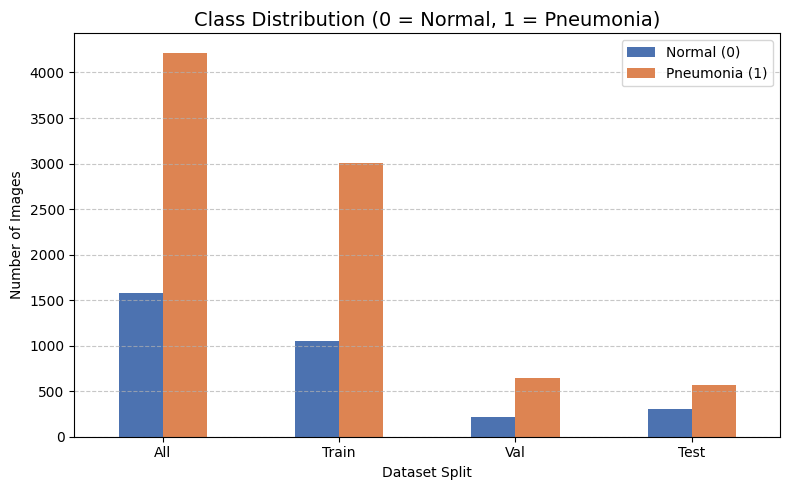

In [66]:
counts_train = df_train_new['label'].value_counts().sort_index()
counts_val = df_val_new['label'].value_counts().sort_index()
counts_test = df_test_new['label'].value_counts().sort_index()
counts_all = df_all_new['label'].value_counts().sort_index()

df_summary = pd.DataFrame({
    'All': counts_all,
    'Train': counts_train,
    'Val': counts_val,
    'Test': counts_test,

}).T.fillna(0).astype(int)

df_summary['Total'] = df_summary[0] + df_summary[1]
df_summary['% Normal (0)'] = (df_summary[0] / df_summary['Total'] * 100).round(1)
df_summary['% Pneumonia (1)'] = (df_summary[1] / df_summary['Total'] * 100).round(1)

print("Class Distribution by Dataset")
display(df_summary)

plt.figure(figsize=(8,5))
df_summary[[0,1]].plot(
    kind='bar',
    stacked=False,
    color=['#4C72B0', '#DD8452'],
    figsize=(8,5)
)
plt.title('Class Distribution (0 = Normal, 1 = Pneumonia)', fontsize=14)
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(['Normal (0)', 'Pneumonia (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Transforms

In [67]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# (A) RGB -------------------------------------------------------------------------
train_transform_rgb_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_transform_rgb_noaug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_test_transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# (B) Grayscale -------------------------------------------------------------------
train_transform_gray_aug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transform_gray_noaug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



In [68]:
class XrayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.filepaths = df["filepath"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = torch.tensor(self.labels[idx]).long()
        with Image.open(img_path) as img:
            if self.transform:
                img = self.transform(img)
        return img, label


def balance_dataset_keep_original(df, target_0=3200, target_1=3500):
    df0 = df[df["label"] == 0]
    df1 = df[df["label"] == 1]

    n0, n1 = len(df0), len(df1)
    print(f"Before: class0={n0}, class1={n1} → total={len(df)}")

    add0 = max(target_0 - n0, 0)
    add1 = max(target_1 - n1, 0)

    df0_aug = df0.sample(add0, replace=True, random_state=42) if add0 > 0 else pd.DataFrame(columns=df.columns)
    df1_aug = df1.sample(add1, replace=True, random_state=42) if add1 > 0 else pd.DataFrame(columns=df.columns)

    df0_final = pd.concat([df0, df0_aug])
    df1_final = pd.concat([df1, df1_aug])

    df_balanced = pd.concat([df0_final, df1_final]).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"After : class0={len(df0_final)}, class1={len(df1_final)} → total={len(df_balanced)}")

    return df_balanced



In [70]:
df_train_balanced = balance_dataset_keep_original(df_train_new, target_0=3200, target_1=3500)

# -------------------- RGB --------------------
train_ds_rgb_aug     = XrayDataset(df_train_balanced, transform=train_transform_rgb_aug)
train_ds_rgb_noaug   = XrayDataset(df_train_new, transform=train_transform_rgb_noaug)
val_ds_rgb           = XrayDataset(df_val_new, transform=val_test_transform_rgb)
test_ds_rgb          = XrayDataset(df_test_new, transform=val_test_transform_rgb)

# -------------------- Grayscale --------------------
train_ds_gray_aug    = XrayDataset(df_train_balanced, transform=train_transform_gray_aug)
train_ds_gray_noaug  = XrayDataset(df_train_new, transform=train_transform_gray_noaug)
val_ds_gray          = XrayDataset(df_val_new, transform=val_test_transform_gray)
test_ds_gray         = XrayDataset(df_test_new, transform=val_test_transform_gray)


Before: class0=1055, class1=3007 → total=4062
After : class0=3200, class1=3500 → total=6700


In [71]:
batch_size = 16

# --- RGB ---
train_loader_rgb_aug    = DataLoader(train_ds_rgb_aug, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader_rgb_noaug  = DataLoader(train_ds_rgb_noaug, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_rgb          = DataLoader(val_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_rgb         = DataLoader(test_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=2)

# --- Grayscale ---
train_loader_gray_aug   = DataLoader(train_ds_gray_aug, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader_gray_noaug = DataLoader(train_ds_gray_noaug, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_gray         = DataLoader(val_ds_gray, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_gray        = DataLoader(test_ds_gray, batch_size=batch_size, shuffle=False, num_workers=2)

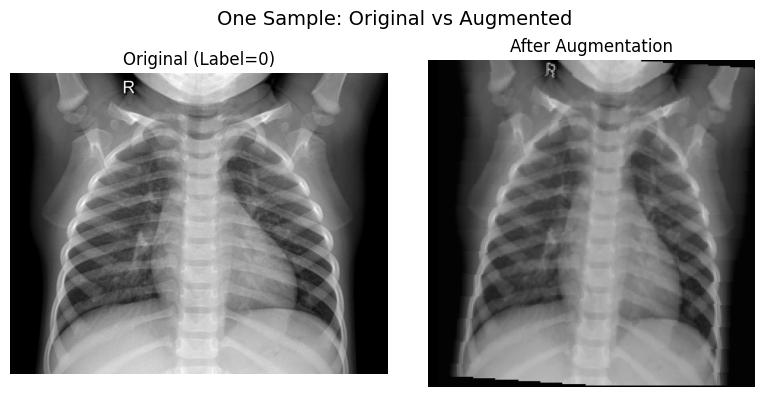

In [72]:
use_rgb = True  
sample = df_train_new.sample(3).iloc[0]
img_path = sample["filepath"]
label = sample["label"]

orig_img = Image.open(img_path)

if use_rgb:
    transform = train_transform_rgb_aug
    mean, std = imagenet_mean, imagenet_std
    orig_img_disp = orig_img.convert("RGB")
else:
    transform = train_transform_gray_aug
    mean, std = [0.5], [0.5]
    orig_img_disp = orig_img.convert("L")

aug_img_tensor = transform(orig_img)
aug_img = aug_img_tensor.clone()

for t, m, s in zip(aug_img, mean, std):
    t.mul_(s).add_(m)
aug_img = torch.clamp(aug_img, 0, 1)
aug_img = aug_img.permute(1, 2, 0).numpy()

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(orig_img_disp, cmap="gray" if not use_rgb else None)
plt.title(f"Original (Label={label})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(aug_img.squeeze(), cmap="gray" if not use_rgb else None)
plt.title("After Augmentation")
plt.axis("off")

plt.suptitle("One Sample: Original vs Augmented", fontsize=14)
plt.tight_layout()
plt.show()


## Model training 